In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix, classification_report, \
                            roc_auc_score, mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE, \
                            mean_squared_error as MSE, accuracy_score, f1_score
import scikitplot as skplt
# !pip install nested-cv
# from nested_cv import NestedCV

In [3]:
%matplotlib inline

### Q4

In [4]:
wdbc_df = pd.read_csv('../hw1/wdbc.data', names= ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness',
                                     'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
                                     'radiusSE', 'textureSE', 'perimeterSE', 'areaSE', 'smoothnessSE', 
                                     'compactnessSE', 'concavitySE', 'concave_pointsSE', 'symmetrySE', 'fractal_dimensionSE',
                                     'radiusW', 'textureW', 'perimeterW', 'areaW', 'smoothnessW', 
                                     'compactnessW', 'concavityW', 'concave_pointsW', 'symmetryW', 'fractal_dimensionW'])
wdbc_df.head()

,ID,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,...,radiusW,textureW,perimeterW,areaW,smoothnessW,compactnessW,concavityW,concave_pointsW,symmetryW,fractal_dimensionW
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
X = wdbc_df.drop("Diagnosis", axis=1)
y = wdbc_df["Diagnosis"].map({'B':0, 'M':1})

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=505)

In [7]:
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

In [8]:
# Show metrics 
def show_metrics(cm):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  = {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision = {:.3f}'.format(tp/(tp+fp)))
    print('Recall    = {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  = {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [9]:
def plot_roc_curve(fpr, tpr, auc_score):
    plt.plot(fpr,tpr,label="auc="+str(auc_score))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()    

In [10]:
def plot_lift_curve(y_test, y_pred):
    """
    https://gsarantitis.wordpress.com/2020/04/29/auc-roc-gains-chart-and-lift-curve-explained-with-business-implications/
    """
    plt.figure(figsize=(7,7))
    skplt.metrics.plot_lift_curve(y_test, y_pred)
    plt.show()    

In [11]:
def gridsearch_customized(X_train, X_test, y_train, y_test, estimator, param_grid, cv=3, scoring='roc_auc'):
    """
    https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
    """
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)
        ])
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scoring)
    grid_result = grid_search.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

    y_pred = grid_search.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1], pos_label=1)

    auc_score = round(auc(fpr, tpr), 4)
    cm = confusion_matrix(y_test, np.where(y_pred[:,1]>=0.5, 1, 0))

    
    print("Prediction ROC-AUC: {}".format(auc_score))    
#     print(classification_report(y_true, np.where(y_pred[:,1]>=0.5, 1, 0)))
    show_metrics(cm)
    
    plot_roc_curve(fpr, tpr, auc_score)
    plot_lift_curve(y_test, y_pred)

### Modeling

#### Decision Tree

Best: 0.975977 using {'estimator__max_depth': 15, 'estimator__min_samples_leaf': 16}
Prediction ROC-AUC: 0.9509
Accuracy  = 0.912
Precision = 0.907
Recall    = 0.867
F1_score  = 0.886


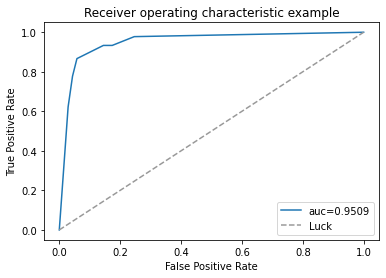

<Figure size 504x504 with 0 Axes>

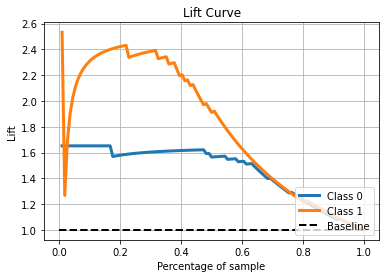

In [12]:
# define models and parameters
tree_clf = DecisionTreeClassifier()
depths = np.arange(1,51,2)
num_leafs = np.arange(1,101)

# define grid search
# tree_param_grid = dict(max_depth=depths, min_samples_leaf=num_leafs)
tree_param_grid = dict(estimator__max_depth=depths, estimator__min_samples_leaf=num_leafs)

gridsearch_customized(X_train, X_test, y_train, y_test, tree_clf, tree_param_grid, cv=3, scoring='roc_auc')

#### KNN

Best: 0.988679 using {'estimator__n_neighbors': 19, 'estimator__weights': 'distance'}
Prediction ROC-AUC: 0.9974
Accuracy  = 0.921
Precision = 1.000
Recall    = 0.800
F1_score  = 0.889


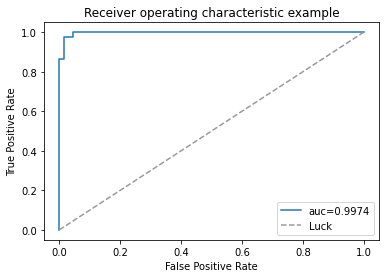

<Figure size 504x504 with 0 Axes>

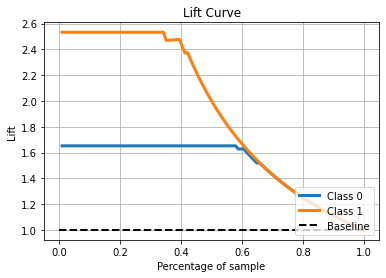

In [13]:
# define models and parameters
knn_clf = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']

# define grid search
# knn_param_grid = dict(n_neighbors=n_neighbors,weights=weights)
knn_param_grid = dict(estimator__n_neighbors=n_neighbors,estimator__weights=weights)

gridsearch_customized(X_train, X_test, y_train, y_test, knn_clf, knn_param_grid, cv=3, scoring='roc_auc')

#### Logistic Regression

Best: 0.994077 using {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
Prediction ROC-AUC: 0.9968
Accuracy  = 0.965
Precision = 0.956
Recall    = 0.956
F1_score  = 0.956


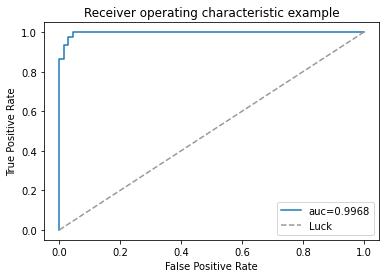

<Figure size 504x504 with 0 Axes>

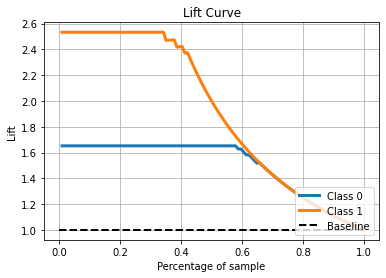

In [14]:
# define models and parameters
lr_clf = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
# lr_param_grid = dict(solver=solvers,penalty=penalty,C=c_values)
lr_param_grid = dict(estimator__solver=solvers,estimator__penalty=penalty,estimator__C=c_values)


gridsearch_customized(X_train, X_test, y_train, y_test, lr_clf, lr_param_grid, cv=3, scoring='roc_auc')

#### SVM

https://chrisalbon.com/machine_learning/support_vector_machines/calibrate_predicted_probabilities_in_svc/

Best: 0.994142 using {'estimator__C': 10, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf'}
Prediction ROC-AUC: 0.9974
Accuracy  = 0.974
Precision = 0.977
Recall    = 0.956
F1_score  = 0.966


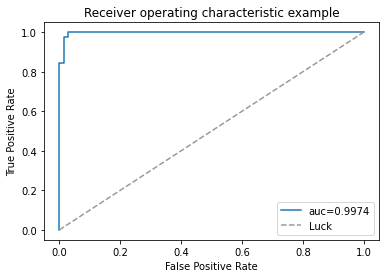

<Figure size 504x504 with 0 Axes>

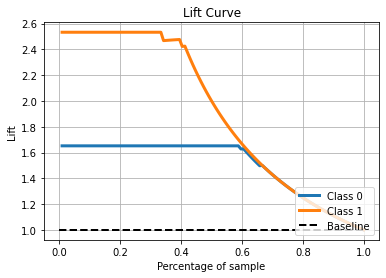

In [15]:
svm_clf = SVC(probability=True)

# define grid search
# svm_param_grid = {'kernel': ['rbf', 'linear'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]}

svm_param_grid = {'estimator__kernel': ['rbf', 'linear'], 'estimator__gamma': [1e-3, 1e-4],
                     'estimator__C': [1, 10, 100, 1000]}

gridsearch_customized(X_train, X_test, y_train, y_test, svm_clf, svm_param_grid, cv=3, scoring='roc_auc')

### Q5

- Code <br>
https://github.com/rasbt/model-eval-article-supplementary/blob/master/code/nested_cv_code.ipynb <br>
https://vitalflux.com/python-nested-cross-validation-algorithm-selection/ <br>
https://datascience.stackexchange.com/questions/13185/nested-cross-validation-and-selecting-the-best-regression-model-is-this-the-ri <br>
https://www.philipscurve.com/post/2020-10-24-nested-cross-validation/ <br>
https://github.com/casperbh96/Nested-Cross-Validation <br>
<br>

- Discuss <br>
https://arxiv.org/pdf/1809.09446.pdf <br> 
https://stackoverflow.com/questions/42742102/what-to-do-with-the-best-score-from-a-grid-search-obtained-from-a-nested-cross-v <br>
https://scikit-learn-general.narkive.com/paMQ55PK/the-proper-way-to-do-nested-cross-validation-with-randomidized-gridsearchcv-pipelines <br>


In [38]:
car_df = pd.read_csv('car.data', names= ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
car_df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


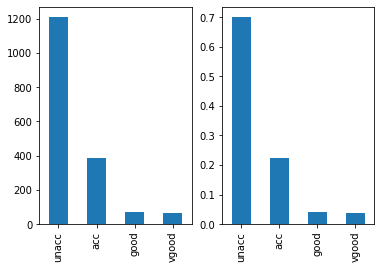

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2)

car_df['class'].value_counts().plot(kind='bar', ax=ax1)
(car_df['class'].value_counts()/np.sum(car_df['class'].value_counts())).plot(kind='bar', ax=ax2)
plt.show()

In [43]:
le = LabelEncoder()
oe = OrdinalEncoder()
ss = StandardScaler()

In [44]:
X = car_df.drop("class", axis=1)
y = car_df["class"]
# ss = StandardScaler()
# X = ss.fit_transform(X)

In [45]:
encode_columns = []
encode_columns.append(list(X.columns))

In [46]:
encode_columns

[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=505)

In [48]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Modeling- NestedCV

In [49]:
models_name = ['DecisionTree', 'KNeighborsClassifier', 'LogisticRegression', 'GaussianNB', 'SVC']
pipe1 = Pipeline([('std', StandardScaler()),
                  ('clf1', DecisionTreeClassifier())])

pipe2 = Pipeline([('std', StandardScaler()),
                  ('clf2', KNeighborsClassifier())])

pipe3 = Pipeline([('std', StandardScaler()),
                  ('clf3', LogisticRegression(multi_class='ovr', solver='liblinear'))])

pipe4 = Pipeline([('std', StandardScaler()),
                  ('clf4', GaussianNB())])

pipe5 = Pipeline([('std', StandardScaler()),
                  ('clf5', SVC())])

models_to_run = [pipe1,pipe2,pipe3,pipe4,pipe5]
models_param_grid = [ 
                    { # 1st param grid, corresponding to DecisionTreeClassifier
                            'clf1__max_depth': range(1,21,2),
                            'clf1__min_samples_leaf': range(1,10),
                            'clf1__min_samples_split' : range(2,5)
                    }, 
                    { # 2nd param grid, corresponding to KNeighborsClassifier
                            'clf2__n_neighbors': range(1, 11),
                            'clf2__p': range(1, 4)
                    },
                    { # 3rd param grid, corresponding to LogisticRegression
                            'clf3__penalty': ['l1', 'l2'],
                            'clf3__C': [100, 10, 1.0, 0.1, 0.01]
                    },
                    { # 4th param grid, corresponding to GaussianNB
                            'clf4__var_smoothing': np.logspace(0,-9, num=100)
                    },
                    { # 5th param grid, corresponding to SVC
                            'clf5__kernel': ['rbf'],
                            'clf5__gamma': [1e-3, 1e-4],
                            'clf5__C': [1, 10, 100, 1000]
                    }    
                    ]

# list(zip(*(models_to_run, models_param_grid, models_name)))

#### Ordinal Encoder Version

In [50]:
X_oe_train = oe.fit_transform(X_train)
X_oe_test = oe.transform(X_test)
# X_oe_train = ss.fit_transform(X_oe_train)
# X_oe_test = ss.transform(X_oe_test)

In [61]:
cv_size = 3
scoring = 'f1_macro'

# inner cv
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=cv_size, shuffle=True, random_state=505)

for est, pgrid, name in zip(*(models_to_run, models_param_grid, models_name)):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring,
                       n_jobs=1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv
    
# outer cv    
model_dct = {}
outer_cv = StratifiedKFold(n_splits=cv_size, shuffle=True, random_state=505)

for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_oe_train,
                                   y=y_train,
                                   cv=outer_cv,
                                   n_jobs=1)
    print('%s | outer f1 macro %.2f%% +/- %.2f' % 
          (name, nested_score.mean() * 100, nested_score.std() * 100))
    
    model_dct['{}'.format(name)] = round(np.mean(nested_score), 2)
    print ('='*100)

best_model = [key for key in model_dct if model_dct[key] == max(model_dct.values())]
print("Best model: {}, with accuracy: {}".format(best_model[0], model_dct[best_model[0]]))        


# for name, gs_est in sorted(gridcvs.items()):
#     nested_score = cross_val_score(gs_est, 
#                                    X=np.concatenate([X_oe_train, X_oe_test]),
#                                    y=np.concatenate([y_train, y_test]),
#                                    cv=outer_cv,
#                                    n_jobs=1)
#     print('%s | outer f1 macro %.2f%% +/- %.2f' % 
#           (name, nested_score.mean() * 100, nested_score.std() * 100))
    
#     model_dct['{}'.format(name)] = round(np.mean(nested_score), 2)
#     print ('='*100)

# best_model = [key for key in model_dct if model_dct[key] == max(model_dct.values())]
# print("Best model: {}, with accuracy: {}".format(best_model[0], model_dct[best_model[0]]))        

DecisionTree | outer f1 macro 94.29% +/- 2.08
GaussianNB | outer f1 macro 49.16% +/- 1.54
KNeighborsClassifier | outer f1 macro 79.03% +/- 1.63
LogisticRegression | outer f1 macro 29.06% +/- 0.83
SVC | outer f1 macro 29.74% +/- 1.41
Best model: DecisionTree, with accuracy: 0.94


### Modeling- GridSearchCV

Best model: DecisionTree
Best Parameters: 0.949437 using {'clf1__max_depth': 15, 'clf1__min_samples_leaf': 1, 'clf1__min_samples_split': 2}
confusion matrix:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x128c6b430>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       384
           1       1.00      1.00      1.00        69
           2       1.00      1.00      1.00      1210
           3       1.00      1.00      1.00        65

    accuracy                           1.00      1728
   macro avg       1.00      1.00      1.00      1728
weighted avg       1.00      1.00      1.00      1728



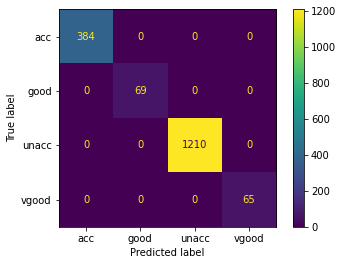

In [62]:
# Fitting a model to the whole training set
# using the "best" algorithm
best_algo = gridcvs[best_model[0]]

best_algo.fit(X_oe_train, y_train)
# best_algo.fit(np.concatenate([X_oe_train, X_oe_test]), np.concatenate([y_train, y_test]))

# summarize results
print("Best model: {}".format(best_model[0])) 
print("Best Parameters: %f using %s" % (best_algo.best_score_, best_algo.best_params_))
means = best_algo.cv_results_['mean_test_score']
stds = best_algo.cv_results_['std_test_score']
params = best_algo.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


y_pred = best_algo.predict(np.concatenate([X_oe_train, X_oe_test]))
# cm = confusion_matrix(np.concatenate([y_train, y_test]), y_pred)

print ('confusion matrix: ', plot_confusion_matrix(best_algo, np.concatenate([X_oe_train, X_oe_test]), \
                                                   np.concatenate([y_train, y_test]), display_labels=le.classes_))
print (classification_report(np.concatenate([y_train, y_test]), y_pred, digits=4))

    
# train_acc = accuracy_score(y_true=y_train, y_pred=best_algo.predict(X_oe_train))
# test_acc = accuracy_score(y_true=y_test, y_pred=best_algo.predict(X_oe_test))

# print('Accuracy %.2f%% (average over CV test folds)' %
#       (100 * best_algo.best_score_))
# print('Best Parameters: %s' % best_algo.best_params_)
# print('Training Accuracy: %.2f%%' % (100 * train_acc))
# print('Test Accuracy: %.2f%%' % (100 * test_acc))

#### One Hot Encoder Version

In [56]:
ohe = OneHotEncoder()
X_ohe_train = ohe.fit_transform(X_train).toarray()
X_ohe_test = ohe.transform(X_test).toarray()

In [63]:
cv_size = 3
scoring = 'f1_macro'

# inner cv
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=cv_size, shuffle=True, random_state=505)

for est, pgrid, name in zip(*(models_to_run, models_param_grid, models_name)):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring,
                       n_jobs=1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv
    
# outer cv    
model_dct = {}
outer_cv = StratifiedKFold(n_splits=cv_size, shuffle=True, random_state=505)


for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_ohe_train,
                                   y=y_train,
                                   cv=outer_cv,
                                   n_jobs=1)
    print('%s | outer f1 macro %.2f%% +/- %.2f' % 
          (name, nested_score.mean() * 100, nested_score.std() * 100))
    
    model_dct['{}'.format(name)] = round(np.mean(nested_score), 2)
    print ('='*100)




# for name, gs_est in sorted(gridcvs.items()):
#     nested_score = cross_val_score(gs_est, 
#                                    X=np.concatenate([X_ohe_train, X_ohe_test]),
#                                    y=np.concatenate([y_train, y_test]),
#                                    cv=outer_cv,
#                                    n_jobs=1)
#     print('%s | outer f1 macro %.2f%% +/- %.2f' % 
#           (name, nested_score.mean() * 100, nested_score.std() * 100))
    
#     model_dct['{}'.format(name)] = round(np.mean(nested_score), 2)
#     print ('='*100)

best_model = [key for key in model_dct if model_dct[key] == max(model_dct.values())]
print("Best model: {}, with accuracy: {}".format(best_model[0], model_dct[best_model[0]]))        

DecisionTree | outer f1 macro 89.54% +/- 4.36
GaussianNB | outer f1 macro 76.05% +/- 1.79
KNeighborsClassifier | outer f1 macro 72.86% +/- 1.68
LogisticRegression | outer f1 macro 74.52% +/- 3.42
SVC | outer f1 macro 96.15% +/- 1.42
Best model: SVC, with accuracy: 0.96


### Modeling- GridSearchCV

Best model: SVC
Best Parameters: 0.961524 using {'clf5__C': 1000, 'clf5__gamma': 0.001, 'clf5__kernel': 'rbf'}
confusion matrix:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x129156700>
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       384
           1       0.97      1.00      0.99        69
           2       1.00      1.00      1.00      1210
           3       1.00      1.00      1.00        65

    accuracy                           1.00      1728
   macro avg       0.99      1.00      0.99      1728
weighted avg       1.00      1.00      1.00      1728



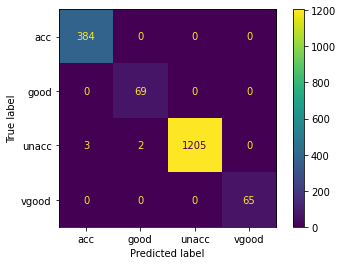

In [64]:
# Fitting a model to the whole training set
# using the "best" algorithm
best_algo = gridcvs[best_model[0]]

best_algo.fit(X_ohe_train, y_train)
# best_algo.fit(np.concatenate([X_ohe_train, X_ohe_test]), np.concatenate([y_train, y_test]))
                             
# summarize results
print("Best model: {}".format(best_model[0])) 
print("Best Parameters: %f using %s" % (best_algo.best_score_, best_algo.best_params_))
means = best_algo.cv_results_['mean_test_score']
stds = best_algo.cv_results_['std_test_score']
params = best_algo.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

    
y_pred = best_algo.predict(np.concatenate([X_ohe_train, X_ohe_test]))
# cm = confusion_matrix(np.concatenate([y_train, y_test]), y_pred)

print ('confusion matrix: ', plot_confusion_matrix(best_algo, np.concatenate([X_ohe_train, X_ohe_test]), \
                                                   np.concatenate([y_train, y_test]), display_labels=le.classes_))
print (classification_report(np.concatenate([y_train, y_test]), y_pred, digits=4))

    
# train_acc = accuracy_score(y_true=y_train, y_pred=best_algo.predict(X_oe_train))
# test_acc = accuracy_score(y_true=y_test, y_pred=best_algo.predict(X_oe_test))

# print('Accuracy %.2f%% (average over CV test folds)' %
#       (100 * best_algo.best_score_))
# print('Best Parameters: %s' % best_algo.best_params_)
# print('Training Accuracy: %.2f%%' % (100 * train_acc))
# print('Test Accuracy: %.2f%%' % (100 * test_acc))